In [15]:
%matplotlib inline

### Tutorial overview
This tutorial provides a demo of how to use Cue to discover variants given a small input BAM file containing alignments of short reads simulated from a synthetic genome to a region of ```GRCh38``` ```chr21```.

The associated YAML config files needed to execute this workflow are provided in the ```data/demo/config``` directory.

The input files needed to run this notebook are stored in the following [Google Cloud Storage bucket](https://console.cloud.google.com/storage/browser/cue-demo) and should be downloaded as described below.

### Initial setup

A pre-installation of [gsutil](https://cloud.google.com/storage/docs/gsutil) from the [Google Cloud CLI](https://cloud.google.com/sdk/docs/install) is required to copy the demo files from Google Cloud Storage. Please ensure that ```gsutil``` works on your system.

In [ ]:
!which gsutil

Set up the local folders for the demo files.

In [26]:
%%sh
mkdir -p ../data/demo/inputs
mkdir -p ../data/demo/ground_truth
mkdir -p ../data/demo/models

Copy all the associated demo files from Google Cloud Storage into the corresponding folders (the input BAM, the VCF with ground-truth variants simulated in the genome, and the Cue model).

In [ ]:
!gsutil cp gs://cue-demo/inputs/chr21.small.bam ../data/demo/inputs/
!gsutil cp gs://cue-demo/inputs/chr21.small.bam.bai ../data/demo/inputs/
!gsutil cp gs://cue-demo/inputs/GRCh38.fa.fai ../data/demo/inputs/
!gsutil cp gs://cue-demo/ground_truth/svs.chr21.small.sorted.vcf.gz ../data/demo/ground_truth/
!gsutil cp gs://cue-demo/ground_truth/svs.chr21.small.sorted.vcf.gz.tbi ../data/demo/ground_truth/
!gsutil cp gs://cue-demo/models/cue.pt ../data/demo/models/

Copy the demo configuration files into the desired results folder. Cue generally writes the results of each command into the parent folder of the provided config file(s).

In [28]:
%%sh
mkdir -p ../data/demo/results
cp ../data/demo/config/data.yaml ../data/demo/results/.
cp ../data/demo/config/model.yaml ../data/demo/results/.

The YAML configuration files contain input parameter settings needed to execute Cue. To perform variant calling, Cue takes a data-specific config file (```data.yaml```) and a model-specific config file (```model.yaml```), which specify parameters used to process the input BAM file and execute the pretrained deep learning model, respectively.

Two parameters are required in the data YAML file: (1) the path to the input BAM file and (2) the reference file index; for example:
```
bam: "data/demo/inputs/chr21.small.bam"
fai: "data/demo/inputs/GRCh38.fa.fai"
```

One parameter is required in the model YAML file -- the path to the pretrained model:

```
model_path: "data/demo/models/cue.pt"
```
Several additional parameters can be optionally controlled by the user (as described in the documentation), while the remaining parameters should be left untouched.

### Structural variant calling

The following command will call variants given the sample input BAM file and the provided pretrained Cue model (in ```data/demo/models```) on a single CPU.
This command will launch Cue in variant discovery mode. The input BAM file will first be indexed and then the genome will be scanned to generate images
and make predictions. This process should take about 5-6 minutes in total on one CPU. This command can be executed on the GPU by providing
the desired GPU id in the ```gpu_ids``` field of the ```model.yaml``` file. For example, to run on GPU 0, set this field as follows:
```gpu_ids: [0]```. Multiple GPU ids can be provided to parallelize SV calling across multiple devices when running on a full-genome dataset.


In [ ]:
%%sh
export PYTHONPATH=${PYTHONPATH}:..
source ../env/bin/activate

python ../engine/call.py --data_config ../data/demo/results/data.yaml --model_config ../data/demo/results/model.yaml

The output of the program will be generated in the ```data/demo/results``` directory.
In particular, the discovered SVs will be provided here: ```data/demo/results/reports/svs.vcf ``` (Cue outputs both a BED and a VCF file with results).

For example, here are five SVs discovered by the model ranked by confidence score (given in ```QUAL``` column).

```
#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO    FORMAT  SAMPLE
chr21	14874025	DEL	N	<DEL>	82	PASS	END=14891603;SVTYPE=DEL;SVLEN=17579	GT	1/1
chr21	14606447	DEL	N	<DEL>	82	PASS	END=14665626;SVTYPE=DEL;SVLEN=59180	GT	1/1
chr21	13073244	DEL	N	<DEL>	82	PASS	END=13108985;SVTYPE=DEL;SVLEN=35742	GT	1/1
chr21	13293752	DUP	N	<DUP>	81	PASS	END=13438087;SVTYPE=DUP;SVLEN=144336	GT	1/1
chr21	14375002	DUP	N	<DUP>	81	PASS	END=14560157;SVTYPE=DUP;SVLEN=185156	GT	1/1
chr21	10396877	DUP	N	<DUP>	81	PASS	END=10428517;SVTYPE=DUP;SVLEN=31641	GT	0/1
chr21	10566604	DEL	N	<DEL>	81	PASS	END=10703517;SVTYPE=DEL;SVLEN=136914	GT	0/1
chr21	14078127	DUP	N	<DUP>	80	PASS	END=14174806;SVTYPE=DUP;SVLEN=96680	GT	0/1
chr21	14019143	INV	N	<INV>	80	PASS	END=14077149;SVTYPE=INV;SVLEN=58007	GT	1/1
chr21	13519143	DEL	N	<DEL>	80	PASS	END=13700587;SVTYPE=DEL;SVLEN=181445	GT	0/1
```

Intermediate model predictions in image space are stored under the ```data/demo/results/reports/predictions/``` directory for ```chr21```, along with images depicting the keypoint predictions (these are reported for result visualization only at specified batch intervals).

In [ ]:
%%sh
cat ../data/demo/results/reports/svs.vcf | grep -v "##" | head -n 11

### Structural variant callset evaluation (Optional)

We can evaluate the calls against the ground truth SVs using Truvari.
In order to execute Truvari, we need to post-process the produced VCF to the input format required by Truvari;
in particular, we need to sort, compress, and index the SV VCF file. We recommend using ```bcftools``` and ```htslib```
for this task as follows.

In [ ]:
%%sh
# a. Sort the VCF by position
bcftools sort ../data/demo/results/reports/svs.vcf > ../data/demo/results/reports/svs.sorted.vcf

# b. Compress the sorted VCF
bgzip -f ../data/demo/results/reports/svs.sorted.vcf

# c. Index the compressed VCF
bcftools index -t ../data/demo/results/reports/svs.sorted.vcf.gz

In [ ]:
%%sh
source ../env/bin/activate

# install Truvari
python -m pip install Truvari

# We can now execute Truvari as follows:
rm -rf ../data/demo/results/reports/truvari
truvari bench -b ../data/demo/ground_truth/svs.chr21.small.sorted.vcf.gz -c ../data/demo/results/reports/svs.sorted.vcf.gz -o ../data/demo/results/reports/truvari --pctsize=0.5 --pctov=0.5 --passonly --sizemax 5000000 --pctsim 0 --gtcomp


Truvari will report the precision, recall, and F1 score for this small benchmark. The above command will require a genotype match to consider an SV call a true positive (TP).

In [33]:
%%sh
# To view the full Truvari summary:
cat ../data/demo/results/reports/truvari/summary.txt

{
    "TP-base": 16,
    "TP-call": 16,
    "FP": 0,
    "FN": 1,
    "precision": 1.0,
    "recall": 0.9411764705882353,
    "f1": 0.9696969696969697,
    "base cnt": 17,
    "call cnt": 16,
    "TP-call_TP-gt": 16,
    "TP-call_FP-gt": 0,
    "TP-base_TP-gt": 16,
    "TP-base_FP-gt": 0,
    "gt_concordance": 1.0,
    "gt_matrix": {
        "(0, 1)": {
            "(0, 1)": 10
        },
        "(1, 1)": {
            "(1, 1)": 6
        }
    }
}

We can see that Cue discovered 16 out of the 17 events simulated in this region with an exact genotype match and no false positives.
Additional information produced by Truvari can be found here: ```data/demo/results/reports/truvari```.

### Visualizing the SVs results

To visually evaluate the results, we can generate annotated Cue images and separate image channels centered around each discovered SV
using the provided ```engine/view.py``` script. These channels can be used to evaluate various alignment signals contributing to each SV call.


In [ ]:
%%sh
source ../env/bin/activate

cp ../data/demo/config/view.yaml ../data/demo/results/.
python ../engine/view.py --config ../data/demo/results/view.yaml

The annotations and channels for the above events can be generated as follows (note that other events may appear in the same image if they are nearby).

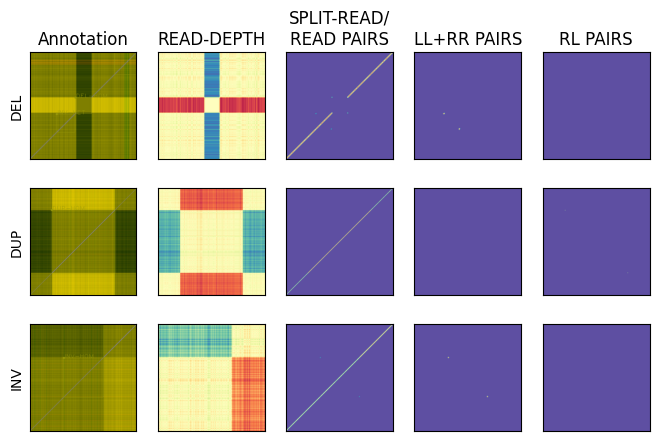

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(imgs, row_labels, col_labels):
    n_rows, n_cols = len(imgs), len(imgs[0])
    fig = plt.figure(figsize=(8,5))
    fig.tight_layout()
    for i in range(n_rows):
        for j in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
            if not i:
                ax.title.set_text(col_labels[j])
            if not j:
                ax.set_ylabel(row_labels[i])
            plt.xticks([])
            plt.yticks([])
            img = imgs[i][j]
            plt.imshow(img, cmap="Spectral_r")
        
# set up the generated image paths
ann_img_prefix = "../data/demo/results/annotated_images/0000000000"
ch_img_prefix = "../data/demo/results/images/0000000000"
img_fnames = {"DEL": "chr21_14824024-14941603_&_chr21_14824024-14941603.png",
              "DUP": "chr21_13243751-13488087_&_chr21_13243751-13488087.png",
              "INV": "chr21_13969142-14127149_&_chr21_13969142-14127149.png",
              }

# load the annotated images for each event
images = [[np.array(Image.open("%s_0_%s" % (ann_img_prefix, img_fnames["DEL"])), copy=False)],
          [np.array(Image.open("%s_3_%s" % (ann_img_prefix, img_fnames["DUP"])), copy=False)],
          [np.array(Image.open("%s_8_%s" % (ann_img_prefix, img_fnames["INV"])), copy=False)]]

# load the image channels for each event
for channel in range(1, 5):
    for i,sv in enumerate(img_fnames.keys()):
        images[i].append(np.array(Image.open("%s_%s.ch%d.png" % (ch_img_prefix, img_fnames[sv], channel)), copy=False))

image_labels = ["Annotation", "READ-DEPTH", "SPLIT-READ/\nREAD PAIRS", "LL+RR PAIRS", "RL PAIRS"]
plot_images(images, list(img_fnames.keys()), image_labels)
